In [1]:
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import psycopg2
from mplsoccer import Pitch, Sbopen, VerticalPitch

## Connecting to Database / Pulling tables 

In [2]:
supabase_password = 'elde5y6u7ycHuiGV'

In [3]:
#connecting to our remote supabase database
conn = psycopg2.connect(
    user="postgres.kacepynzaervoccjqxxz",
    password=supabase_password,
    host="aws-0-us-east-1.pooler.supabase.com",
    port=5432,
    database="postgres"
)

In [4]:
cursor = conn.cursor()

cursor.execute("""
    SELECT * FROM events;
""")

#retreiving our events data 
records = cursor.fetchall()
all_events = pd.DataFrame(records, columns=[desc[0] for desc in cursor.description])

In [5]:
cursor.execute("""
    SELECT * FROM players;
""")

#retreiving our players data
records = cursor.fetchall()
all_players = pd.DataFrame(records, columns=[desc[0] for desc in cursor.description])

In [6]:
cursor.execute(""" 
    SELECT * FROM matches;
""")

records = cursor.fetchall()
all_matches = pd.DataFrame(records, columns=[desc[0] for desc in cursor.description])

In [7]:
cursor.execute("""
    SELECT * FROM lineups 
    WHERE team_id = 65;
""")
records = cursor.fetchall()
fcb_lineups = pd.DataFrame(records, columns=[desc[0] for desc in cursor.description])

## Team Analysis

In [ ]:
all_events.loc[:, 'period'] = all_events['period'].replace({'FirstHalf': 1, 'SecondHalf': 2})
all_events.loc[all_events['type'] == 'Goal', 'is_goal'] = True

In [ ]:
barca_data = all_events[all_events['team_id'] == 65]
barca_data.head()

In [ ]:
barca_data.shape

In [ ]:
#get a list of all the games by Barcelona, either home or away 
match_ids = barca_data['match_id'].unique().tolist()

In [ ]:
#calculate the number of games
no_games = len(match_ids)
no_games

In [47]:
team = "FC Barcelona"

In [ ]:
danger_passes = pd.DataFrame()
for period in [1,2]:
    #keep only the successful passes by Barcelona in this period 
    mask_pass = (barca_data.type == "Pass") & (barca_data.outcome_type == "Successful") & (barca_data.period == period)
    #keep only the necessary columns
    passes = barca_data.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second", "player_id"]]
    #keep only shots by Barcelona in this period 
    mask_shot = (barca_data.is_shot == True) & (barca_data.period == period)
    #keep only the necessary columns 
    shots = barca_data.loc[mask_shot, ["minute", "second"]]
    #convert time to seconds
    shot_times = shots['minute']*60+shots['second']
    shot_window = 15
    #find starts of the window 
    shot_start = shot_times - shot_window 
    #condition to avoid negative shot starts
    shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)
    #convert to seconds
    pass_times = passes['minute']*60+passes['second']
    #check if pass is in any of the windows for this half 
    pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

    #keep only danger passes
    danger_passes_period = passes.loc[pass_to_shot]
    #concatenate dataframe with a previous one to keep danger passes from the whole tournament
    danger_passes = pd.concat([danger_passes, danger_passes_period], ignore_index = True)

In [ ]:
danger_passes.head()

In [ ]:
#plot vertical pitch
pitch = Pitch(pitch_type='opta', line_zorder=2, line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#get the 2D histogram
bin_statistic = pitch.bin_statistic(danger_passes.x, danger_passes.y, statistic='count', bins=(6, 5), normalize=False)
#normalize by number of games
bin_statistic["statistic"] = bin_statistic["statistic"]/no_games
#make a heatmap
pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Danger passes by ' + team + " per game\n(2023/2024 Season)", fontsize = 20)
plt.show()

In [ ]:
danger_passes = (
    danger_passes
    .merge(all_players, on='player_id', how='left')
    .loc[:, ['x', 'y', 'end_x', 'end_y', 'minute', 'second', 'name']]
    .rename(columns={'name': 'player_name'})
)

In [ ]:
danger_passes.head()

In [ ]:
#keep only surnames
danger_passes["player_name"] = danger_passes["player_name"].apply(lambda x: str(x).split()[-1])
#count passes by player and normalize them
pass_count = danger_passes.groupby(["player_name"]).x.count()/no_games
#make a histogram
ax = pass_count.plot.bar(pass_count)
#make legend
ax.set_xlabel("")
ax.set_ylabel("Number of danger passes per game")
plt.show()

## Opponent Analysis

In [19]:
opponent_data = all_events[all_events['team_id'] != 65]
opponent_data.head()

,event_id,match_id,minute,second,expanded_minute,team_id,player_id,related_player_id,x,y,...,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type,is_goal,type,outcome_type,period
0,2607249059,1734775,0,0.0,0,53,362602,NaN,49.8,49.9,...,NaN,NaN,NaN,NaN,False,False,False,Pass,Successful,FirstHalf
1,2607249065,1734775,0,2.0,0,53,106586,NaN,38.3,44.9,...,NaN,NaN,NaN,NaN,False,False,False,Pass,Successful,FirstHalf
2,2607249083,1734775,0,5.0,0,53,78500,NaN,34.6,14.5,...,NaN,NaN,NaN,NaN,False,False,False,Pass,Successful,FirstHalf
3,2607249099,1734775,0,6.0,0,53,381510,NaN,54.6,12.9,...,NaN,NaN,NaN,NaN,False,False,False,Pass,Successful,FirstHalf
4,2607249107,1734775,0,8.0,0,53,255182,NaN,47.1,7.7,...,NaN,NaN,NaN,NaN,False,False,False,Pass,Unsuccessful,FirstHalf


In [ ]:
opponent_data.shape

In [21]:
#keep only the shots by the opponents
mask_shots = (opponent_data.is_shot == True)
shots_against = opponent_data.loc[mask_shots, ["event_id", "match_id", "x", "y", "minute", "second","expanded_minute", "is_goal", "type", "period", "player_id"]].reset_index(drop=True)
shots_against['is_goal'] = [True if x == 'Goal' else False for x in shots_against['type']]
shots_against.head()

,event_id,match_id,x,y,minute,second,expanded_minute,is_goal,type,period,player_id
0,2607251785,1734775,76.8,46.8,4,3.0,4,False,SavedShot,FirstHalf,255182
1,2607262491,1734775,85.4,34.1,20,11.0,20,False,SavedShot,FirstHalf,255182
2,2607262553,1734775,81.3,45.1,20,15.0,20,False,SavedShot,FirstHalf,255182
3,2607262999,1734775,86.9,44.5,20,58.0,20,False,MissedShots,FirstHalf,357839
4,2607263021,1734775,88.6,67.2,20,59.0,20,False,MissedShots,FirstHalf,127392


In [ ]:
#setting up the pitch 
pitch = VerticalPitch(pitch_type='opta', line_zorder=2, line_color='black', half = True)
fig, ax = pitch.grid(nrows=1, ncols=1, axis=False, endnote_height=0.05)

#plotting each shot
for row in shots_against.itertuples():
    if row.is_goal == True:
        alpha = 1
    else:
        alpha = 0.2
    pitch.scatter(
        row.x, 
        row.y, 
        alpha = alpha, 
        s = 100, 
        color = "red", 
        ax=ax['pitch'],
        edgecolors="black"
    )

#plotting the avg shot location (blue)
pitch.scatter(
    shots_against.x.mean(),
    shots_against.y.mean(),
    alpha = 1,
    s = 250,
    color = "blue",
    ax = ax['pitch'],
    edgecolors = "black"
)
pitch.annotate('Average shot location', (shots_against.x.mean() -1, shots_against.y.mean() - 3), ax=ax['pitch'], fontsize = 10)

#plotting the avg goal location (green)
avg_x = shots_against.loc[shots_against["is_goal"] == True, 'x'].mean()
avg_y = shots_against.loc[shots_against["is_goal"] == True, 'y'].mean()
pitch.scatter(
    avg_x,
    avg_y,
    alpha = 1,
    s = 250,
    color = "green",
    ax = ax['pitch'],
    edgecolors = "black"
)
pitch.annotate('Average goal location', (avg_x - 1, avg_y - 3), ax=ax['pitch'], fontsize = 10)
ax['pitch'].set_title(f'Goals and Shots conceded by {team} 2023/2024 season')


In [ ]:
#setting up the pitch 
pitch = VerticalPitch(pitch_type='opta', line_zorder=2, line_color='black', half = True)
fig, axs = pitch.grid(nrows=1, ncols=2, axis=False, endnote_height=0.05)

#get the 2D Histogram
shot_statistic = pitch.bin_statistic(
    shots_against.x,
    shots_against.y,
    statistic='count',
    bins=(6,5),
    normalize=False
)

#normalize by the total # of games 
shot_statistic["statistic"] = shot_statistic["statistic"]/no_games

#create the heatmap
pcm = pitch.heatmap(shot_statistic, cmap='Reds', edgecolor='grey', ax=axs['pitch'][0])
#legend to the plot 
ax_cbar = fig.add_axes((-0.05, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
axs['pitch'][0].set_title('Shots conceded heatmap')

#get the 2D Histogram
goal_statistic = pitch.bin_statistic(
    shots_against.loc[shots_against['is_goal'] == True].x,
    shots_against.loc[shots_against['is_goal'] == True].y,
    statistic='count',
    bins=(6,5),
    normalize=False
)
#normalize by the total # of games 
goal_statistic["statistic"] = goal_statistic["statistic"]/no_games
#create the heatmap
pcm = pitch.heatmap(goal_statistic, cmap='Reds', edgecolor='grey', ax=axs['pitch'][1])
#legend to the plot 
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
axs['pitch'][1].set_title('Goals conceded heatmap')

fig.suptitle(f"Shots and Goals Against {team} in 2023/24 La Liga season", fontsize = 30)
plt.show()



In [ ]:
# path effects
path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]

#KPI : goal to shot ratio
pitch = VerticalPitch(pitch_type='opta', line_zorder=2, line_color='black', half = True)
fig, axs = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#get the 2D Histogram
goal_statistic = pitch.bin_statistic(
    shots_against.loc[shots_against['is_goal'] == True].x,
    shots_against.loc[shots_against['is_goal'] == True].y,
    statistic='count',
    bins=(6,5),
    normalize=False
)

#get the 2D Histogram
shot_statistic = pitch.bin_statistic(
    shots_against.x,
    shots_against.y,
    statistic='count',
    bins=(6,5),
    normalize=False
)

goal_shot_ratio = goal_statistic.copy()
goal_shot_ratio["statistic"] = np.divide(goal_statistic["statistic"], shot_statistic["statistic"])
goal_shot_ratio["statistic"] = np.nan_to_num(goal_shot_ratio["statistic"])

pcm = pitch.heatmap(goal_shot_ratio, cmap='Reds', edgecolor='grey', ax=axs['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
labels = pitch.label_heatmap(goal_shot_ratio, color='#f4edf0', fontsize=18,
                             ax=axs['pitch'], ha='center', va='center',
                             str_format='{:.0%}', zorder=1, path_effects=path_eff)
fig.suptitle('Goals per shot ratio')
fig.set_figwidth(5)
fig.set_figheight(5)

## Player level analysis 

In [18]:
fcb_lineups = pd.merge(fcb_lineups, all_matches[['match_id', 'match_minutes', 'match_minutes_expanded']], on='match_id', how='left')

In [27]:
def calculate_from_to(row):
    if row['first_eleven']:
        if pd.isnull(row['subbed_out_period']):
            from_time = '00:00'
            to_time = f"{int(row['match_minutes_expanded']):02d}:00"
        else:
            from_time = '00:00'
            to_time = f"{int(row['subbed_out_expanded_min']):02d}:00"
    else:
        if pd.isnull(row['subbed_in_period']):
            from_time = to_time = '00:00'
        else:
            from_time = f"{int(row['subbed_in_expanded_min']):02d}:00"
            if pd.isnull(row['subbed_out_period']):
                to_time = f"{int(row['match_minutes_expanded']):02d}:00"
            else:
                to_time = f"{int(row['subbed_out_expanded_min']):02d}:00"
    return pd.Series({'from': from_time, 'to': to_time})

In [35]:
def calculate_minutes_played(row):
    from_time = row['from'].split(':')
    to_time = row['to'].split(':')
    
    from_minutes = int(from_time[0])
    to_minutes = int(to_time[0]) 
    
    return to_minutes - from_minutes

In [40]:
match_lineups = fcb_lineups.apply(calculate_from_to, axis=1)
match_lineups = pd.concat([fcb_lineups, match_lineups], axis=1)
match_lineups['minutes_played'] = match_lineups.apply(calculate_minutes_played, axis=1)

match_lineups = match_lineups.loc[:, ['match_id', 'player_id', 'player_name', 'player_position', 'match_minutes_expanded', 'from', 'to', 'minutes_played']]


In [44]:
# Create empty lists to store shots and goals conceded
shots_conceded_list = []
goals_conceded_list = []
# Iterate over each row in match_lineups
for index, row in match_lineups.iterrows():
    match_id = row['match_id']
    from_time = row['from']
    to_time = row['to']

    # Filter shots_against based on match_id and time period
    filtered_shots = shots_against[(shots_against['match_id'] == match_id) &
                                   (shots_against['expanded_minute'] >= int(from_time.split(':')[0])) &
                                   (shots_against['expanded_minute'] <= int(to_time.split(':')[0]))]
    
    # Count the number of shots and goals conceded
    shots_conceded = len(filtered_shots)
    goals_conceded = filtered_shots['is_goal'].sum()

    # Append the counts to the lists
    shots_conceded_list.append(shots_conceded)
    goals_conceded_list.append(goals_conceded)


# Add shots_conceded and goals_conceded columns to match_lineups DataFrame
match_lineups['shots_conceded'] = shots_conceded_list
match_lineups['goals_conceded'] = goals_conceded_list

In [50]:
#lets print some team info 
goals = len(shots_against.loc[shots_against['type'] == 'Goal'])
shots = len(shots_against)
print(f"{team} conceded {goals} goals. An average of {round(goals/30,2)} goals per match.")
print(f"{team} conceded {shots} shots. An average of {round(shots/30,2)} shots per match.")
print(f"{team} received a ratio of {round(shots/goals, 2)} shots per goal.")

FC Barcelona conceded 43 goals. An average of 1.43 goals per match.
FC Barcelona conceded 322 shots. An average of 10.73 shots per match.
FC Barcelona received a ratio of 7.49 shots per goal.


In [51]:
#creating KPIs : Shots per minute and Goals per minute 
kpi_data = match_lineups.groupby('player_id')[['minutes_played', 'shots_conceded', 'goals_conceded']].sum()

kpi_data['shots_per_minute'] = kpi_data['shots_conceded'] / kpi_data['minutes_played']
kpi_data['goals_per_minute'] = kpi_data['goals_conceded'] / kpi_data['minutes_played']
kpi_data['shots_per_90'] = kpi_data['shots_per_minute']*90
kpi_data['goals_per_90'] = kpi_data['goals_per_minute']*90
kpi_data['goals_shot_ratio'] = kpi_data['shots_per_90'] / kpi_data['goals_per_90']

kpi_data = kpi_data.reset_index().merge(match_lineups[['player_id', 'player_name']].drop_duplicates(), on = 'player_id')

# Remove players with an average of minutes per game below 10
kpi_data = kpi_data[kpi_data['minutes_played'] >= 10*30]
kpi_data = kpi_data.sort_values('shots_per_minute', ascending=False)
display(kpi_data)


,player_id,minutes_played,shots_conceded,goals_conceded,shots_per_minute,goals_per_minute,shots_per_90,goals_per_90,goals_shot_ratio,player_name
14,367164,1196,140,25,0.117057,0.020903,10.535117,1.881271,5.600000,Iñaki Peña
35,498386,419,49,11,0.116945,0.026253,10.525060,2.362768,4.454545,Pau Cubarsí
5,90782,526,61,8,0.115970,0.015209,10.437262,1.368821,7.625000,Sergi Roberto
6,106885,901,104,13,0.115427,0.014428,10.388457,1.298557,8.000000,Íñigo Martínez
3,84008,338,39,8,0.115385,0.023669,10.384615,2.130178,4.875000,Marcos Alonso
12,349760,1441,164,23,0.113810,0.015961,10.242887,1.436502,7.130435,Ferran Torres
26,463838,957,108,12,0.112853,0.012539,10.156740,1.128527,9.000000,Fermín López
4,90780,1142,126,15,0.110333,0.013135,9.929947,1.182137,8.400000,Oriol Romeu
7,128967,2172,239,32,0.110037,0.014733,9.903315,1.325967,7.468750,João Cancelo
11,301019,2290,251,34,0.109607,0.014847,9.864629,1.336245,7.382353,Jules Koundé


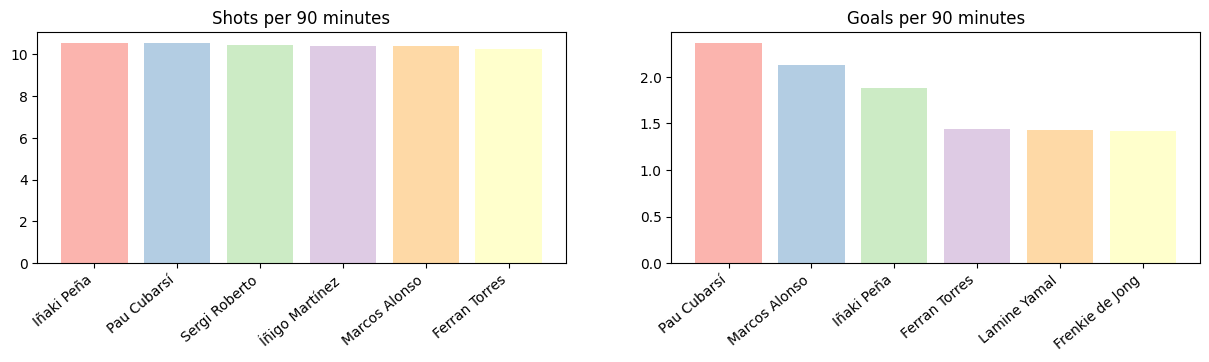

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3))
cmap = plt.get_cmap('Pastel1')

ax0 = kpi_data.sort_values('shots_per_minute', ascending=False).head(6)
axs[0].bar(ax0['player_name'], ax0['shots_per_90'], color=cmap.colors[:6])
ax1 = kpi_data.sort_values('goals_per_90', ascending=False).head(6)
axs[1].bar(ax1['player_name'], ax1['goals_per_90'], color=cmap.colors[:6])

axs[0].set_xticklabels(ax0.player_name, rotation=40, ha='right')
axs[1].set_xticklabels(ax1.player_name, rotation=40, ha='right')
axs[0].set_title('Shots per 90 minutes')
axs[1].set_title('Goals per 90 minutes')

plt.show()